In [29]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate
from keras.layers import Input, LSTM, GRU, Bidirectional, Dense
from keras.models import Model, load_model

from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn.metrics import roc_auc_score

In [2]:
# link to data here

In [2]:
max_squence_length = 100
max_vocab_size = 20000
embedding_dim = 100

In [3]:
word2vec_file_path = 'data/glove.6B.{}d.txt'.format(embedding_dim)
toxic_file_path = 'data/train.csv'
toxic_test_file_path = 'data/test.csv'

In [4]:
def get_word2vec(file_name):
    word2vec = {}
    with open(file_name, 'r') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vec = np.array(values[1:], dtype=np.float32)
            word2vec[word] = vec
    return word2vec

In [5]:
def get_toxic_data(file_name):
    train = pd.read_csv(file_name)
    sentences = train["comment_text"].fillna("DUMMY_VALUE").values
    labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    targets = train[labels].values
    return sentences, labels, targets  

In [6]:
word2vec = get_word2vec(word2vec_file_path)
sentences, labels, targets = get_toxic_data(toxic_file_path)

In [7]:
print('# of words: ', len(word2vec))

# of words:  400000


In [8]:
# tokenizer = Tokenizer()
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

# note the index starts from 1 instead of 0
word2index = tokenizer.word_index

In [9]:
index2word = {index:word for word, index in word2index.items()}

In [10]:
print(len(word2index))
print(len(index2word))

210337
210337


In [11]:
index2word[1]

'the'

In [12]:
num_vocab = min(len(word2index) + 1, max_vocab_size)

embedding_matrix = np.zeros((num_vocab, embedding_dim))
for word, index in word2index.items():
    if index < max_vocab_size:
        vec = word2vec.get(word)
        if vec is not None:
            embedding_matrix[index] = vec

print(embedding_matrix.shape)

(20000, 50)


In [13]:
data = pad_sequences(sequences, maxlen=max_squence_length)
print(data.shape)

(159571, 100)


In [14]:
type(data)
train_data = data[:140000]
test_data = data[140000:]
train_targets = targets[:140000]
test_targets = targets[140000:]
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(140000, 100)
(19571, 100)
(140000, 6)
(19571, 6)


## 2. Embedding Layer

In [ ]:
embedding_layer = Embedding(
    embedding_matrix.shape[0],
    embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=max_squence_length,
    trainable=False)

## 3. CNN Model

In [27]:
def CNN_MODEL(max_squence_length, num_classes):
    input_ = Input(shape=(max_squence_length, ))
    x = embedding_layer(input_)
    x = Conv1D(128, 3, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = MaxPooling1D(3)(x)
    # x = Conv1D(128, 3, activation='relu')(x)
    # x = MaxPooling1D(3)(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = Dropout(0.5)(x)
    max_pool = GlobalMaxPooling1D()(x)
    avg_pool = GlobalAveragePooling1D()(x)
    concatenated_tensor = Concatenate(axis=1)([max_pool, avg_pool])
    x = Dense(128, activation='relu')(concatenated_tensor)
    output = Dense(num_classes, activation='sigmoid')(x)

    model = Model(input_, output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [30]:
cnn_model = CNN_MODEL(max_squence_length, len(labels))
plot_model(cnn_model, 
           to_file='./model_images/cnn_model.png', 
           show_shapes=True, 
           show_layer_names=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 50)      1000000     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 98, 128)      19328       embedding_1[2][0]                
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 98, 128)      0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
max_poolin

<img src='./model_images/cnn_model.png'/>

In [31]:
validation_split = 0.2
batch_size = 512
epochs = 10

file_name = "./models/cnn_model/weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(file_name, monitor='val_acc', 
                             save_best_only=True, mode='max', verbose=1)

r = model.fit(train_data, train_targets, batch_size=batch_size, 
                      callbacks=[checkpoint],
                      epochs = epochs, validation_split=validation_split)

Train on 112000 samples, validate on 28000 samples
Epoch 1/10
112000/112000 [==============================] - 95s 845us/step - loss: 0.0795 - acc: 0.9729 - val_loss: 0.1254 - val_acc: 0.9740

Epoch 00001: val_acc improved from -inf to 0.97401, saving model to ./models/weights-improvement-01-0.9740.hdf5
Epoch 2/10
112000/112000 [==============================] - 104s 933us/step - loss: 0.0755 - acc: 0.9743 - val_loss: 0.1202 - val_acc: 0.9739

Epoch 00002: val_acc did not improve from 0.97401
Epoch 3/10
112000/112000 [==============================] - 101s 901us/step - loss: 0.0723 - acc: 0.9753 - val_loss: 0.1136 - val_acc: 0.9760

Epoch 00003: val_acc improved from 0.97401 to 0.97596, saving model to ./models/weights-improvement-03-0.9760.hdf5
Epoch 4/10
112000/112000 [==============================] - 104s 931us/step - loss: 0.0706 - acc: 0.9759 - val_loss: 0.1016 - val_acc: 0.9759

Epoch 00004: val_acc did not improve from 0.97596
Epoch 5/10
112000/112000 [=========================

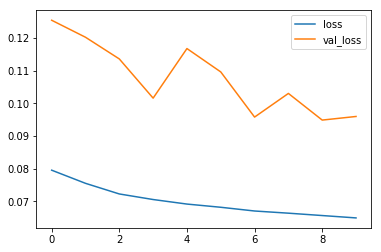

In [32]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

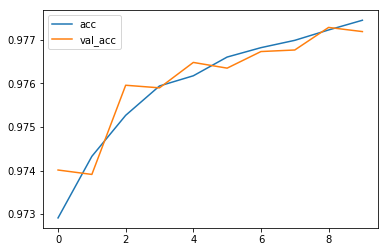

In [33]:
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [34]:
cnn_model = load_model('./models/cnn_model/weights-improvement-09-0.9773.hdf5')

In [35]:
p = cnn_model.predict(test_data)

In [36]:
aucs = []
for j in range(6):
    auc = roc_auc_score(test_targets[:, j], p[:, j])
    aucs.append(auc)

In [37]:
print(np.mean(aucs))

0.9574932716300424


## 4. RNN Model

In [38]:
input_ = Input(shape=(max_squence_length, ))
x = embedding_layer(input_)
x = Bidirectional(LSTM(64, dropout=0.5))(x)
output = Dense(len(labels), activation='sigmoid')(x)
model = Model(input_, output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               58880     
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 774       
Total params: 1,059,654
Trainable params: 59,654
Non-trainable params: 1,000,000
_________________________________________________________________


In [39]:
validation_split = 0.2
batch_size = 512
epochs = 5

In [40]:
file_name = "./models/rnn_model/weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(file_name, monitor='val_acc', save_best_only=True, 
                             mode='max', verbose=1)

r = model.fit(train_data, train_targets, batch_size=batch_size, callbacks=[checkpoint]
              epochs = epochs, validation_split=validation_split)

Train on 112000 samples, validate on 28000 samples
Epoch 1/5
112000/112000 [==============================] - 205s 2ms/step - loss: 0.1464 - acc: 0.9538 - val_loss: 0.0815 - val_acc: 0.9711
Epoch 2/5
112000/112000 [==============================] - 212s 2ms/step - loss: 0.0811 - acc: 0.9723 - val_loss: 0.0707 - val_acc: 0.9756
Epoch 3/5
112000/112000 [==============================] - 223s 2ms/step - loss: 0.0733 - acc: 0.9749 - val_loss: 0.0663 - val_acc: 0.9773
Epoch 4/5
112000/112000 [==============================] - 209s 2ms/step - loss: 0.0696 - acc: 0.9760 - val_loss: 0.0628 - val_acc: 0.9782
Epoch 5/5
112000/112000 [==============================] - 220s 2ms/step - loss: 0.0673 - acc: 0.9765 - val_loss: 0.0629 - val_acc: 0.9786


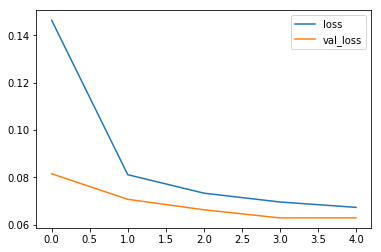

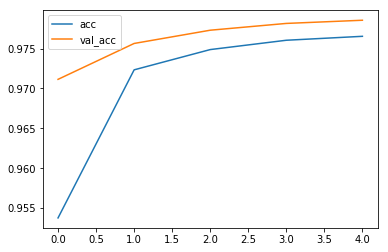

In [41]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [42]:
p = model.predict(test_data)

In [43]:
aucs = []
for j in range(6):
    auc = roc_auc_score(test_targets[:, j], p[:, j])
    aucs.append(auc)
    
print(np.mean(aucs))

0.956662727458652
